# 21-01 주제분석 3주차 패키지

### 27기 고경현

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [2]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

## 1. Interpretable ML

### 1.1 모델 불러오기


In [3]:
import pickle 
import joblib

In [4]:
lgbm = pd.read_pickle("lgbm.pkl")

### 1.2 Feature Importance 확인과 해석

- 불러온 모델에 대해 `plot_importance`함수를 통해 Feature Importance를 시각화해주세요.
- 결과에 대해 간단히 해석해주세요.

여기서 Feature Importance는 Permutation를 통한 중요도를 보는 것이 아니고, tree 모델 자체의 구성에서 어떤 변수가 지니불순도를 잘 줄였는지를 확인한 것이라고 이해해주시면 됩니다. 

In [5]:
from lightgbm import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

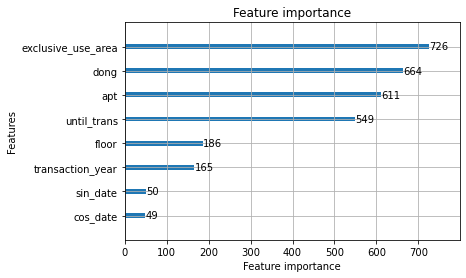

In [6]:
plot_importance(lgbm)

`exlusive_use_area`,`dong`,`apt`,`until_trans` 변수 순으로 트리가 나뉠 때 지니 불순도를 많이 줄이는 것으로 보입니다. 이 네 개가 가장 두드러지며 그 다음으로는 `floor` 와 `transaction_year` 가 지니 불순도를 줄이는 것으로 보입니다. 마지막으로 1년을 10일 단위로 나누어 삼각변환을 한 `sin_date`와 `cos_date`는 다른 변수들에 비해 지니 불순도를 줄이는 데에 큰 기여를 하지 못하는 것으로 보입니다. 가장 처음에 말한 네 변수가 부동산 가격에 직접적인 연향을 미치는지는 단언할 수는 없지만, 부동산 가격을 예측하는 데에는 큰 영향을 미친다고 생각 할 수 있습니다. 


### 1.3 Randomness Control

- `random, numpy` 패키지의 난수를 42로 고정하세요.
- 더불어서 `os` 패키지의 난수도 고정해야합니다.

Permutation 방식의 Feature Importance를 시행한건데, permutation자체에 랜덤성이 있다보니 결과가 재현 가능하도록 시드를 고정해줍니다.

파이썬의 시드 고정은 R처럼 그냥 `set.seed()`한다고 해서 고정되지 않습니다. 전체 파이썬과 여러 패키지들의 randomness를 각각 고정해주어야 재현가능해집니다. 정말 귀찮고, 딥러닝의 경우 GPU를 사용할 경우 GPU의 계산과 관련된 시드를 고정하면 속도가 상당히 느려진다고 알려져 있습니다. 더불어서 재현도 100%되진 않으며 성능도 살짝 떨어진다고는 하지만, GPU를 사용하지 않는 경우에는 문제가 없고 최소한 할줄은 알아야겠죠?

더불어서 왜 저런식으로 복잡하게 구성이 되는가?에 대해 궁금할 수 있는데 찾아본 적은 없지만 아마도 `numpy`는 c++가 뒤에서 연산을 해주는 것으로 알고있고(그래서 빠름!), `random`은 그냥 파이썬이고, `os`는 우리 os를 건드리는 것이 아닐까....? 추측입니다 :)

In [7]:
import random
import os

In [8]:
random.seed(42)
np.random.seed(42)

### 1.4 Permutation Feature Importance

- permutation feature importance를 계산하기 위해 `best_lgbm_reg`를 `permutation_importance`함수를 사용해 test set에 적합하세요.
- permutation feature importance를 시각화해주세요.


In [9]:
from sklearn.inspection import permutation_importance

In [10]:
perm_imp = permutation_importance(best_lgbm_reg, test_cbe, test_y, random_state=42)
perm_imp_mean = perm_imp["importances_mean"]

In [11]:
perm_imp_mean

array([-126811.13013175, -139385.86769624, -153106.48788039,
        -13477.3647413 ,       0.        ,  -51303.43641936,
          1260.43431207,     819.19005935])

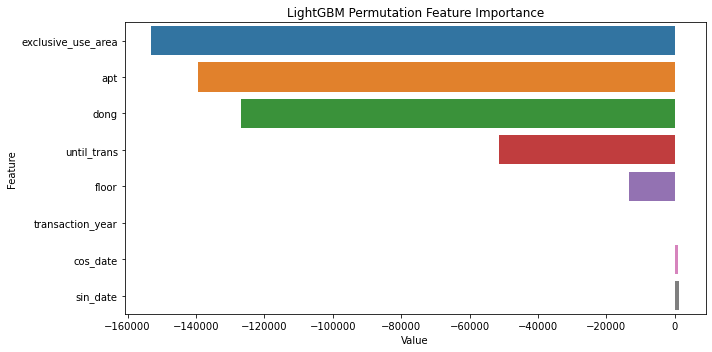

In [12]:
feature_col = test_cbe.columns

feature_imp = pd.DataFrame(sorted(zip(perm_imp_mean, feature_col)), columns=['Value','Feature'])

plt.figure(figsize=(10,5))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Permutation Feature Importance')
plt.tight_layout()


우선 `transaction_year`을 포함한 아래 세개의 변수는 값 자체의 변동폭이 크지 않거나 없기 때문에 permutation importance가 0에 가깝게 나온 것 같습니다. 또한 나머지 5개의 변수는 음수가 나오는데 이는 실제 데이터보다 각 변수들이 랜덤으로 permute 되었을 때 가격 예측이 더 정확해진다는 의미라고 합니다.

### 1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석

- SHAP Value를 구하고 간단한 해석을 해주세요.
- `shap.TreeExplainer`, `shap_values`, `shap.summary_plot` 정도의 함수만 사용하면 됩니다.
- 결과가 좀 다른건 상관없습니다
.

In [13]:
#! pip install shap

In [14]:
import shap

In [15]:
shap_val = shap.TreeExplainer(best_lgbm_reg).shap_values(test_cbe)

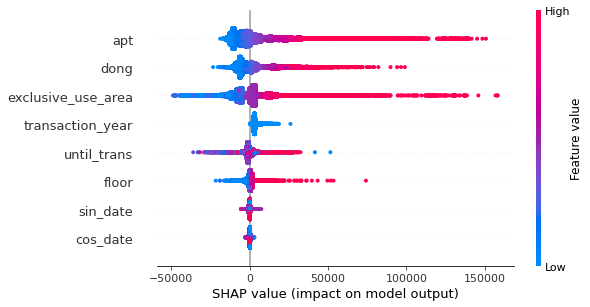

In [16]:
shap.summary_plot(shap_val, test_cbe)

- 오른쪽의 feature value를 통해 `apt` 부터 `cos_date` 순으로 price를 예측하는 데에 지니 불순도를 크게 감소시킨다고 볼 수 있습니다.
- SHAP value가 0인 지점에서 점들이 많이 분포해있는 것을 볼 수 있는데, 이는 가격에 큰 변동을 주지 못하는(= SHAP value가 0 주변인) 관측치들이 꽤 있는 것으로 생각합니다.
- SHAP value가 양수인 쪽의 관측치들(y축 기준 오른쪽)이 음수인 쪽의 관측치들(y축 기준 왼쪽)에 비해 variation이 큰 것을 통해 가격을 대부분의 변수는 price를 증가시키는 데에 기여를 하며, 그 증가폭이 감소폭에 비해 크다는 것을 알 수 있습니다 
- `transaction_year`, `sin_date`, `cos_date` 변수가 유독 SHAP value의 변동폭이 작았는데, 그 이유는 다음과 같다고 생각합니다.
    - `transaction_year`의 경우, 이 summary plot에 사용된 데이터는 test 데이터 값이고, 데이터에서 `transaction_year`의 값은 5뿐입니다. 그렇기 때문에 변수 자체 값의 variation이 작아 그만큼 price를 예측하는 데에는 큰 변화를 주지 못한 것이라고 생각합니다.
    - `sin_date`와 `cos_date`의 경우에도 `transaction_year`와 비슷하게 가지는 값이 -1, 0 ,1 세 가지로 값의 variation이 크지 않아 price 예측에 큰 영향을 주지 못한 것이라고 생각합니다.

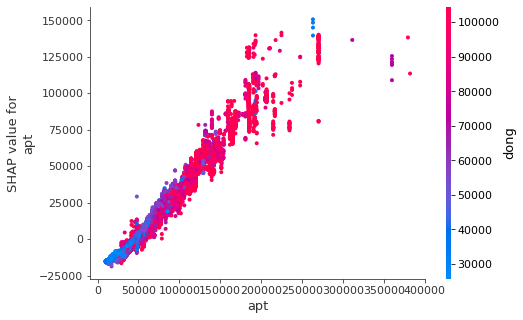

In [17]:
shap.dependence_plot("apt", shap_val, test_cbe)

추가적으로 `apt`변수의 dependence_plot을 보면 `price`변수와 선형관계이며, `dong`변수와 dependency가 가장 큰 것을 알 수 있었습니다.
이는 `apt`변수와 `dong`변수가 `price`에 의해 catboost encoding 되었기 때문이라고도 생각 할 수 있고, 전반적으로 가격이 높은 부동산이 위치한 행정동에는 가격이 높은 아파트가 있는 당연한 사실 때문이라고도 생각했습니다. 

## 2. 딥러닝

### 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.

In [19]:
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [20]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [21]:
train_tune_cbe.keys()

Index(['dong', 'apt', 'exclusive_use_area', 'floor', 'transaction_year',
       'until_trans', 'sin_date', 'cos_date'],
      dtype='object')

In [22]:
def build_model1():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [23]:
model1 = build_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________



- 현재의 신경망은 총 3개의 은닉층으로 구성되어 있습니다 첫 번째 은닉층은 입력층에서 받은 데이터를 256차원(노드)으로 바꿔주며 두 번째는 첫 번째 은닉층에서의 출력 값을 64차원(노드)으로, 세 번째에서는 32차원(노드)으로 변환합니다. 
- 입력층의 개수(차원)는 기존 `train_tune_cbe` 데이터의 feature 개수이고, 각 층에서의 활성화 함수로는 0보다 작으면 0을, 크면 그 자체를 반환하는 `RELU` 함수를 사용하고 있습니다. 
- 또한 출력층에서는 회귀 문제이기 때문에 별다른 함수를 사용하고 있지 않습니다(=항등 함수 사용). 
- 손실 함수와 평가 지표로는 `MSE`를 사용하고 있습니다. 이를 최소화 하기 위한 파라미터를 찾기 위한 옵티마이저로는 `learning_rate`를 0.0001로 하는 `RMSprop`를 사용하고 있습니다.

### 2.2 training loss와 validation loss를 시각화하세요.

- 본인 컴에서 돌리면 꽤나 돌아갈수도 있어요. 주분과 함께하려면 패키지가 코랩으로 가거나, 주분이 코랩으로 가면 한번에 투 컴을 돌릴 수 있습니다.

In [25]:
history = model1.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 2s 2ms/step - loss: 1672292856.2614 - mse: 1672292856.2614 - val_loss: 333764864.0000 - val_mse: 333764864.0000
Epoch 2/300
611/611 [==============================] - 1s 2ms/step - loss: 236315851.7386 - mse: 236315851.7386 - val_loss: 322807968.0000 - val_mse: 322807968.0000
Epoch 3/300
611/611 [==============================] - 1s 2ms/step - loss: 237627326.3268 - mse: 237627326.3268 - val_loss: 346732416.0000 - val_mse: 346732416.0000
Epoch 4/300
611/611 [==============================] - 1s 2ms/step - loss: 227887302.5359 - mse: 227887302.5359 - val_loss: 348441952.0000 - val_mse: 348441952.0000
Epoch 5/300
611/611 [==============================] - 1s 2ms/step - loss: 230693863.2157 - mse: 230693863.2157 - val_loss: 342216512.0000 - val_mse: 342216512.0000
Epoch 6/300
611/611 [==============================] - 1s 2ms/step - loss: 230869280.7582 - mse: 230869280.7582 - val_loss: 323492800.0000 - val_mse: 323492800.0000
Epoch 7/

611/611 [==============================] - 1s 2ms/step - loss: 197692603.8170 - mse: 197692603.8170 - val_loss: 312835456.0000 - val_mse: 312835456.0000
Epoch 51/300
611/611 [==============================] - 1s 2ms/step - loss: 195712283.9739 - mse: 195712283.9739 - val_loss: 305917280.0000 - val_mse: 305917280.0000
Epoch 52/300
611/611 [==============================] - 1s 2ms/step - loss: 191675404.0784 - mse: 191675404.0784 - val_loss: 288714336.0000 - val_mse: 288714336.0000
Epoch 53/300
611/611 [==============================] - 1s 2ms/step - loss: 195095798.7712 - mse: 195095798.7712 - val_loss: 302664416.0000 - val_mse: 302664416.0000
Epoch 54/300
611/611 [==============================] - 1s 2ms/step - loss: 193461531.2680 - mse: 193461531.2680 - val_loss: 314114080.0000 - val_mse: 314114080.0000
Epoch 55/300
611/611 [==============================] - 1s 2ms/step - loss: 191153828.7582 - mse: 191153828.7582 - val_loss: 363822208.0000 - val_mse: 363822208.0000
Epoch 56/300
611/

611/611 [==============================] - 1s 2ms/step - loss: 183520281.9739 - mse: 183520281.9739 - val_loss: 293871168.0000 - val_mse: 293871168.0000
Epoch 100/300
611/611 [==============================] - 1s 2ms/step - loss: 184403307.3725 - mse: 184403307.3725 - val_loss: 287852768.0000 - val_mse: 287852768.0000
Epoch 101/300
611/611 [==============================] - 1s 2ms/step - loss: 180400981.6471 - mse: 180400981.6471 - val_loss: 278176096.0000 - val_mse: 278176096.0000
Epoch 102/300
611/611 [==============================] - 1s 2ms/step - loss: 182385516.1830 - mse: 182385516.1830 - val_loss: 327650336.0000 - val_mse: 327650336.0000
Epoch 103/300
611/611 [==============================] - 1s 2ms/step - loss: 181811320.9281 - mse: 181811320.9281 - val_loss: 327956288.0000 - val_mse: 327956288.0000
Epoch 104/300
611/611 [==============================] - 1s 2ms/step - loss: 183577692.6275 - mse: 183577692.6275 - val_loss: 374617408.0000 - val_mse: 374617408.0000
Epoch 105/30

611/611 [==============================] - 1s 2ms/step - loss: 170312507.5294 - mse: 170312507.5294 - val_loss: 325543296.0000 - val_mse: 325543296.0000
Epoch 149/300
611/611 [==============================] - 1s 2ms/step - loss: 179627131.6209 - mse: 179627131.6209 - val_loss: 279014400.0000 - val_mse: 279014400.0000
Epoch 150/300
611/611 [==============================] - 1s 2ms/step - loss: 176729365.9085 - mse: 176729365.9085 - val_loss: 369223392.0000 - val_mse: 369223392.0000
Epoch 151/300
611/611 [==============================] - 1s 2ms/step - loss: 181640285.0980 - mse: 181640285.0980 - val_loss: 326221216.0000 - val_mse: 326221216.0000
Epoch 152/300
611/611 [==============================] - 1s 2ms/step - loss: 176095100.9542 - mse: 176095100.9542 - val_loss: 301210784.0000 - val_mse: 301210784.0000
Epoch 153/300
611/611 [==============================] - 1s 2ms/step - loss: 177371909.5163 - mse: 177371909.5163 - val_loss: 313506048.0000 - val_mse: 313506048.0000
Epoch 154/30

611/611 [==============================] - 1s 2ms/step - loss: 173487507.3987 - mse: 173487507.3987 - val_loss: 306571200.0000 - val_mse: 306571200.0000
Epoch 198/300
611/611 [==============================] - 1s 2ms/step - loss: 180869288.2614 - mse: 180869288.2614 - val_loss: 284577792.0000 - val_mse: 284577792.0000
Epoch 199/300
611/611 [==============================] - 1s 2ms/step - loss: 172975104.1176 - mse: 172975104.1176 - val_loss: 238724432.0000 - val_mse: 238724432.0000
Epoch 200/300
611/611 [==============================] - 1s 2ms/step - loss: 174911407.5817 - mse: 174911407.5817 - val_loss: 329387328.0000 - val_mse: 329387328.0000
Epoch 201/300
611/611 [==============================] - 1s 2ms/step - loss: 173507404.5359 - mse: 173507404.5359 - val_loss: 304756224.0000 - val_mse: 304756224.0000
Epoch 202/300
611/611 [==============================] - 1s 2ms/step - loss: 177354614.3268 - mse: 177354614.3268 - val_loss: 279972512.0000 - val_mse: 279972512.0000
Epoch 203/30

611/611 [==============================] - 1s 2ms/step - loss: 167496713.5686 - mse: 167496713.5686 - val_loss: 313167712.0000 - val_mse: 313167712.0000
Epoch 247/300
611/611 [==============================] - 1s 2ms/step - loss: 170365597.8562 - mse: 170365597.8562 - val_loss: 273771584.0000 - val_mse: 273771584.0000
Epoch 248/300
611/611 [==============================] - 1s 2ms/step - loss: 172284214.3268 - mse: 172284214.3268 - val_loss: 294939136.0000 - val_mse: 294939136.0000
Epoch 249/300
611/611 [==============================] - 1s 2ms/step - loss: 167192270.6667 - mse: 167192270.6667 - val_loss: 270962496.0000 - val_mse: 270962496.0000
Epoch 250/300
611/611 [==============================] - 1s 2ms/step - loss: 164393106.6536 - mse: 164393106.6536 - val_loss: 247022432.0000 - val_mse: 247022432.0000
Epoch 251/300
611/611 [==============================] - 1s 2ms/step - loss: 166077131.0327 - mse: 166077131.0327 - val_loss: 265985840.0000 - val_mse: 265985840.0000
Epoch 252/30

611/611 [==============================] - 1s 2ms/step - loss: 162095964.3529 - mse: 162095964.3529 - val_loss: 328524768.0000 - val_mse: 328524768.0000
Epoch 296/300
611/611 [==============================] - 1s 2ms/step - loss: 161382994.7320 - mse: 161382994.7320 - val_loss: 264061824.0000 - val_mse: 264061824.0000
Epoch 297/300
611/611 [==============================] - 1s 2ms/step - loss: 173632892.7843 - mse: 173632892.7843 - val_loss: 324737984.0000 - val_mse: 324737984.0000
Epoch 298/300
611/611 [==============================] - 1s 2ms/step - loss: 160476394.2614 - mse: 160476394.2614 - val_loss: 286029568.0000 - val_mse: 286029568.0000
Epoch 299/300
611/611 [==============================] - 1s 2ms/step - loss: 169266002.5882 - mse: 169266002.5882 - val_loss: 279481536.0000 - val_mse: 279481536.0000
Epoch 300/300
611/611 [==============================] - 1s 2ms/step - loss: 158183227.1242 - mse: 158183227.1242 - val_loss: 228225840.0000 - val_mse: 228225840.0000


In [26]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

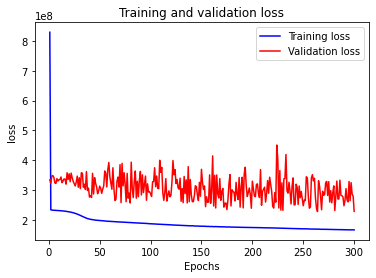

In [36]:
history_dict = history.history
mse = history_dict['mse']
val_mse = history_dict['val_mse']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'b', label='Training loss')  
plt.plot(epochs, val_mse, 'r', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

### 2.3 어떤문제가 발생했는지 설명해주세요.

- 전형적으로 epoch가 증가함에 따라 training loss는 적어지지만 validation mse의 분산이 커지는 overfitting이 발생하고 있음을 알 수 있습니다.


### 2.4 더 좋은 성능의 딥러닝 모델을 위해

- test set에 대해 딥러닝 모형의 성능을 평가하세요.
- dense 조절, batch_size 조절, regularization, dropout, batch normalization 등의 방법을 활용해 최고의 성능을 얻어보세요.
- 만약 성능의 향상이 어렵다면, 다양한 방법들을 시도하는 것을 목표로 해주세요!

In [28]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [29]:
tf.compat.v1.random.set_random_seed(42)

In [30]:
loss_and_mse = model1.evaluate(test_cbe, test_y, batch_size=512)
print("## evaluation for the test data##")
print(loss_and_mse)

179/179 [==============================] - 0s 1ms/step - loss: 4097071360.0000 - mse: 4097071360.0000
## evaluation for the test data##
[4097071360.0, 4097071360.0]


### 추가 모델

In [31]:
from keras.models import load_model

In [32]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [33]:
test_model = build_model()
test_model

- optimizer : Adam
- epoch : 200
- batch_size : 256

In [39]:
test_history = test_model.fit(train_cbe, train_y, epochs=200, validation_data = (test_cbe, test_y), batch_size = 256)

Epoch 1/200
1650/1650 [==============================] - 2s 1ms/step - loss: 178551136.0000 - mse: 178551136.0000 - val_loss: 3599703808.0000 - val_mse: 3599703808.0000
Epoch 2/200
1650/1650 [==============================] - 3s 2ms/step - loss: 178396752.0000 - mse: 178396752.0000 - val_loss: 3788287488.0000 - val_mse: 3788287488.0000
Epoch 3/200
1650/1650 [==============================] - 3s 2ms/step - loss: 177464256.0000 - mse: 177464256.0000 - val_loss: 3466185216.0000 - val_mse: 3466185216.0000
Epoch 4/200
1650/1650 [==============================] - 2s 1ms/step - loss: 177828224.0000 - mse: 177828224.0000 - val_loss: 3495032064.0000 - val_mse: 3495032064.0000
Epoch 5/200
1650/1650 [==============================] - 3s 2ms/step - loss: 177154544.0000 - mse: 177154544.0000 - val_loss: 3787110400.0000 - val_mse: 3787110400.0000
Epoch 6/200
1650/1650 [==============================] - 3s 2ms/step - loss: 176650720.0000 - mse: 176650720.0000 - val_loss: 3650450432.0000 - val_mse: 36

1650/1650 [==============================] - 2s 1ms/step - loss: 166840432.0000 - mse: 166840432.0000 - val_loss: 3505945600.0000 - val_mse: 3505945600.0000
Epoch 50/200
1650/1650 [==============================] - 2s 1ms/step - loss: 166301024.0000 - mse: 166301024.0000 - val_loss: 3707742720.0000 - val_mse: 3707742720.0000
Epoch 51/200
1650/1650 [==============================] - 2s 1ms/step - loss: 166349744.0000 - mse: 166349744.0000 - val_loss: 3591873792.0000 - val_mse: 3591873792.0000
Epoch 52/200
1650/1650 [==============================] - 2s 1ms/step - loss: 166487824.0000 - mse: 166487824.0000 - val_loss: 3854358784.0000 - val_mse: 3854358784.0000
Epoch 53/200
1650/1650 [==============================] - 2s 1ms/step - loss: 166107456.0000 - mse: 166107456.0000 - val_loss: 3657771264.0000 - val_mse: 3657771264.0000
Epoch 54/200
1650/1650 [==============================] - 2s 1ms/step - loss: 165701824.0000 - mse: 165701824.0000 - val_loss: 3209677568.0000 - val_mse: 320967756

1650/1650 [==============================] - 2s 1ms/step - loss: 144616416.0000 - mse: 144616416.0000 - val_loss: 3652507392.0000 - val_mse: 3652507392.0000
Epoch 98/200
1650/1650 [==============================] - 2s 1ms/step - loss: 144172128.0000 - mse: 144172128.0000 - val_loss: 3830920192.0000 - val_mse: 3830920192.0000
Epoch 99/200
1650/1650 [==============================] - 2s 1ms/step - loss: 144739424.0000 - mse: 144739424.0000 - val_loss: 4323744256.0000 - val_mse: 4323744256.0000
Epoch 100/200
1650/1650 [==============================] - 2s 1ms/step - loss: 142627264.0000 - mse: 142627264.0000 - val_loss: 3170302464.0000 - val_mse: 3170302464.0000
Epoch 101/200
1650/1650 [==============================] - 2s 1ms/step - loss: 142767984.0000 - mse: 142767984.0000 - val_loss: 4769772032.0000 - val_mse: 4769772032.0000
Epoch 102/200
1650/1650 [==============================] - 2s 1ms/step - loss: 143053936.0000 - mse: 143053936.0000 - val_loss: 4175048448.0000 - val_mse: 417504

1650/1650 [==============================] - 2s 1ms/step - loss: 130041616.0000 - mse: 130041616.0000 - val_loss: 3987109376.0000 - val_mse: 3987109376.0000
Epoch 146/200
1650/1650 [==============================] - 2s 1ms/step - loss: 127821144.0000 - mse: 127821144.0000 - val_loss: 4306319360.0000 - val_mse: 4306319360.0000
Epoch 147/200
1650/1650 [==============================] - 2s 1ms/step - loss: 128178776.0000 - mse: 128178776.0000 - val_loss: 4180959488.0000 - val_mse: 4180959488.0000
Epoch 148/200
1650/1650 [==============================] - 2s 1ms/step - loss: 128157080.0000 - mse: 128157080.0000 - val_loss: 4088623872.0000 - val_mse: 4088623872.0000
Epoch 149/200
1650/1650 [==============================] - 2s 1ms/step - loss: 127367672.0000 - mse: 127367672.0000 - val_loss: 4767312384.0000 - val_mse: 4767312384.0000
Epoch 150/200
1650/1650 [==============================] - 2s 1ms/step - loss: 127179368.0000 - mse: 127179368.0000 - val_loss: 4917352960.0000 - val_mse: 4917

Epoch 193/200
1650/1650 [==============================] - 3s 2ms/step - loss: 122643680.0000 - mse: 122643680.0000 - val_loss: 4396733952.0000 - val_mse: 4396733952.0000
Epoch 194/200
1650/1650 [==============================] - 2s 1ms/step - loss: 121539728.0000 - mse: 121539728.0000 - val_loss: 4553822208.0000 - val_mse: 4553822208.0000
Epoch 195/200
1650/1650 [==============================] - 2s 1ms/step - loss: 123259496.0000 - mse: 123259496.0000 - val_loss: 5179020288.0000 - val_mse: 5179020288.0000
Epoch 196/200
1650/1650 [==============================] - 2s 1ms/step - loss: 121590672.0000 - mse: 121590672.0000 - val_loss: 3965406464.0000 - val_mse: 3965406464.0000
Epoch 197/200
1650/1650 [==============================] - 2s 1ms/step - loss: 121404728.0000 - mse: 121404728.0000 - val_loss: 5281942016.0000 - val_mse: 5281942016.0000
Epoch 198/200
1650/1650 [==============================] - 2s 1ms/step - loss: 122473384.0000 - mse: 122473384.0000 - val_loss: 4108254464.0000 -

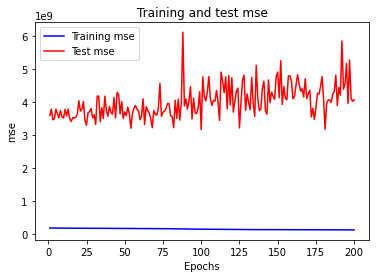

In [40]:
test_history_dict = test_history.history
mse = test_history_dict['mse']
val_mse = test_history_dict['val_mse']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'b', label='Training mse')  
plt.plot(epochs, val_mse, 'r', label='Test mse') 
plt.title('Training and test mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()

plt.show()

adam 옵티마이저를 사용하고 에포크와 배치 사이즈 모두 줄여보았으나, 성능이 더 악화되었습니다 (so sad... adam이 무조건 좋은 건 아닌 걸로..)